In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [69]:
path = '/Users/sheenmccullough/Documents/Kaggle/M5Forecasting/'

calendar = pd.read_csv(path+'calendar.csv')
trainData = pd.read_csv(path+'sales_train_validation.csv')
sellprices = pd.read_csv(path+'sell_prices.csv')

In [70]:
def Convert_to_transaction(df):
    
    '''
    convert our sales data into a daily transacitons set using the pandas melt function
    '''
    list_id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'] 
    d_columns = df.drop(list_id_vars,axis=1)
    df_melted_sales = df.melt(id_vars = list_id_vars, value_vars = d_columns.columns, var_name = 'days', value_name = 'sales') 
    
    
    return df_melted_sales



In [71]:
# This usually takes 16-19 sec to run

train_df_melt = Convert_to_transaction(trainData)

In [72]:
train_df = train_df_melt[['store_id','item_id','cat_id','state_id','days','sales']]



In [73]:
del train_df_melt
del trainData
gc.collect()

23277

In [74]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [75]:
train_df = pd.merge(train_df,calendar[['d','wday','wm_yr_wk','event_name_1','date','year']],left_on='days',
                    right_on='d')

In [76]:
texas = train_df[train_df['state_id']=='TX']

In [77]:
daily_sales = texas.groupby(['date'])['sales'].sum()

### basic time series equation

$$ Sales_{t+1} = f(Sales_t,Sales_{t-1},Sales_{t-2},Sales_{t-3}....,error), $$
#### Where t+1 is the next day and t-1 is the previous day. T-2 is two days prior and so on..This simplistic model's future prediction is only based on past sales values, but not on any external variables which might affect sales. The error term on the right allows for random variation

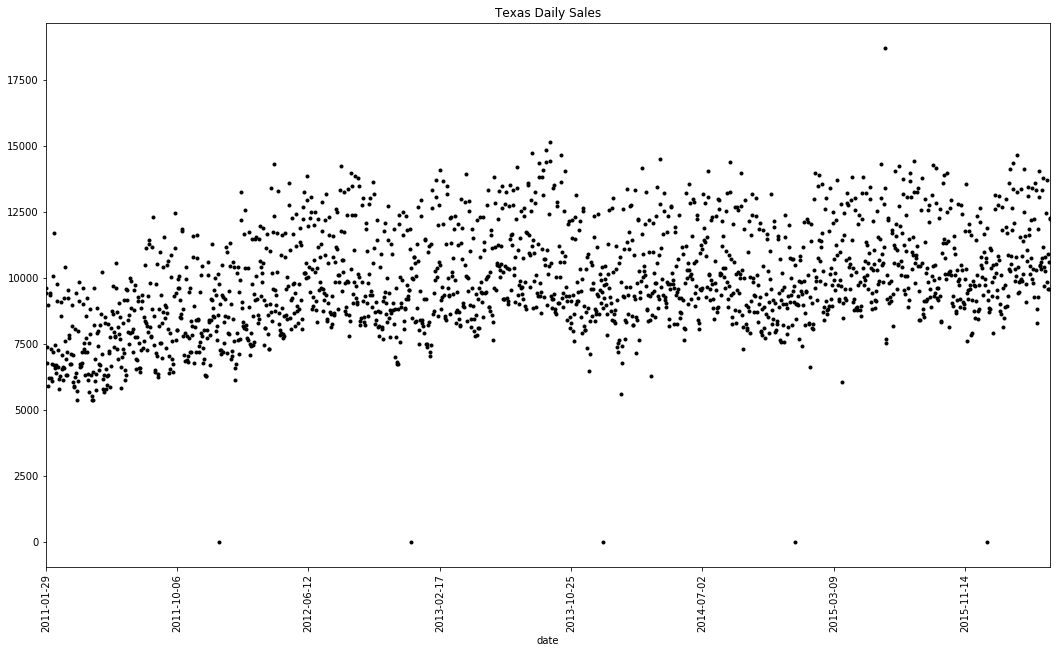

In [78]:
## texas daily sales
plt.title('Texas Daily Sales')
daily_sales.plot(style='k.',figsize=(18,10))
plt.xticks(rotation='vertical')
plt.show()


## seasonal plot

In [97]:
def seasonalplot(df):
    
    data=df[['year','date','sales']]
    unique_yrs = list(data['year'].drop_duplicates())
    for y in unique_yrs:
        yr_df = data[data['year']==y]
        yr_df['Month'] =pd.DatetimeIndex( yr_df['date']).month
        grpd = yr_df.groupby(['Month'])['sales'].sum()
        grpd.plot(figsize=(18,10))
    
    plt.legend(unique_yrs,fontsize=12,loc='upper left')
    plt.show()
    
        
    

/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

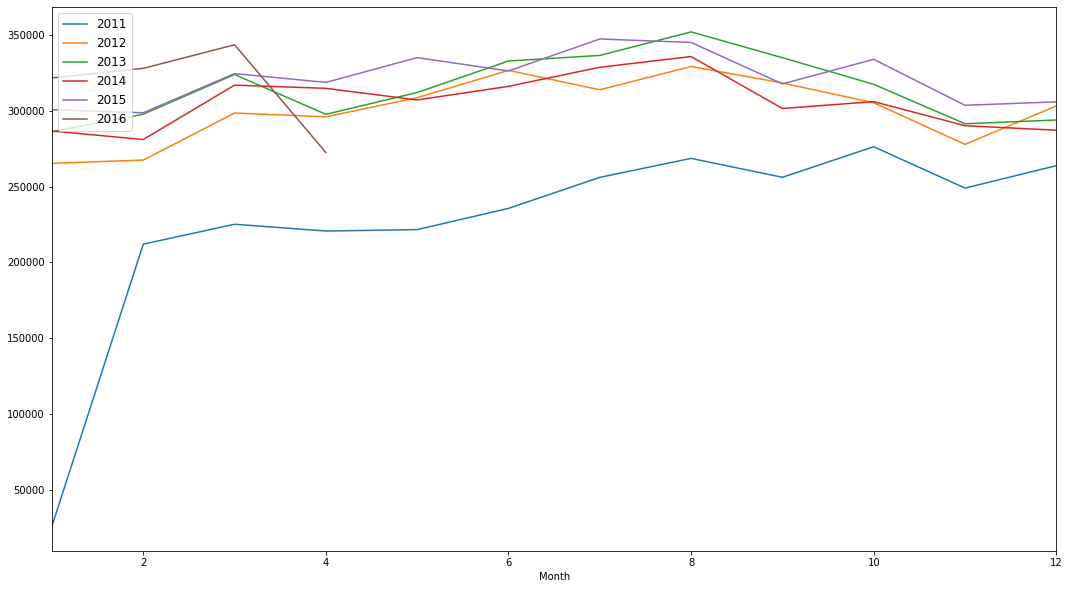

In [98]:
seasonalplot(texas)

In [134]:
def subseriesboxplot(df):
    data=df[['year','date','sales']]
    dfgr = data.groupby(['date'])['sales'].sum().reset_index()
    dfgr['month'] = pd.DatetimeIndex(dfgr['date']).month
    
    plt.figure(figsize=(18,10))
    ax = sns.boxplot(x='month',y='sales',data=dfgr)
    print(dfgr['sales'].describe())
    
    

count     1913.000000
mean      9879.250392
std       1964.928938
min          2.000000
25%       8608.000000
50%       9647.000000
75%      11171.000000
max      18733.000000
Name: sales, dtype: float64


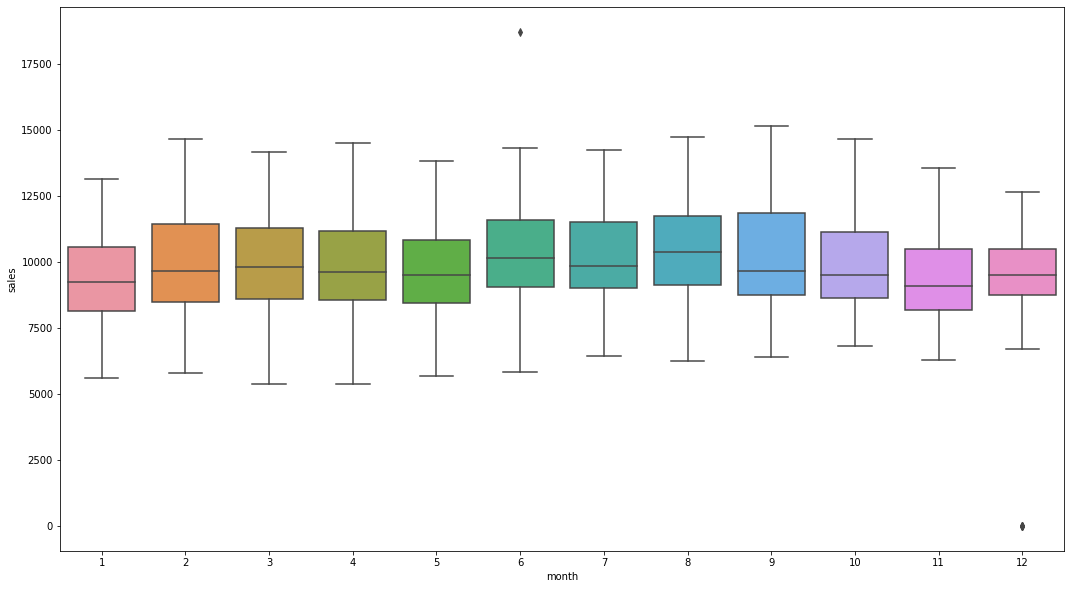

In [135]:
subseriesboxplot(texas)

In [166]:
def scatterbyday(df):
    data=df[['year','date','sales']]
    data['dayofyear'] = pd.DatetimeIndex(data['date']).dayofyear
    
    for y in list(data['year'].drop_duplicates()):
        dfgr = data[data['year']==y]
        dfgr = dfgr.groupby(['dayofyear'])['sales'].sum()
        dfgr.plot(figsize=(18,10))
    plt.legend(list(data['year'].drop_duplicates()),fontsize=12,loc='upper left')
    plt.show()
    
    dayofyear = data.groupby(['dayofyear'])['sales'].sum()
    dayofyear.plot(figsize=(18,10))

/Users/sheenmccullough/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


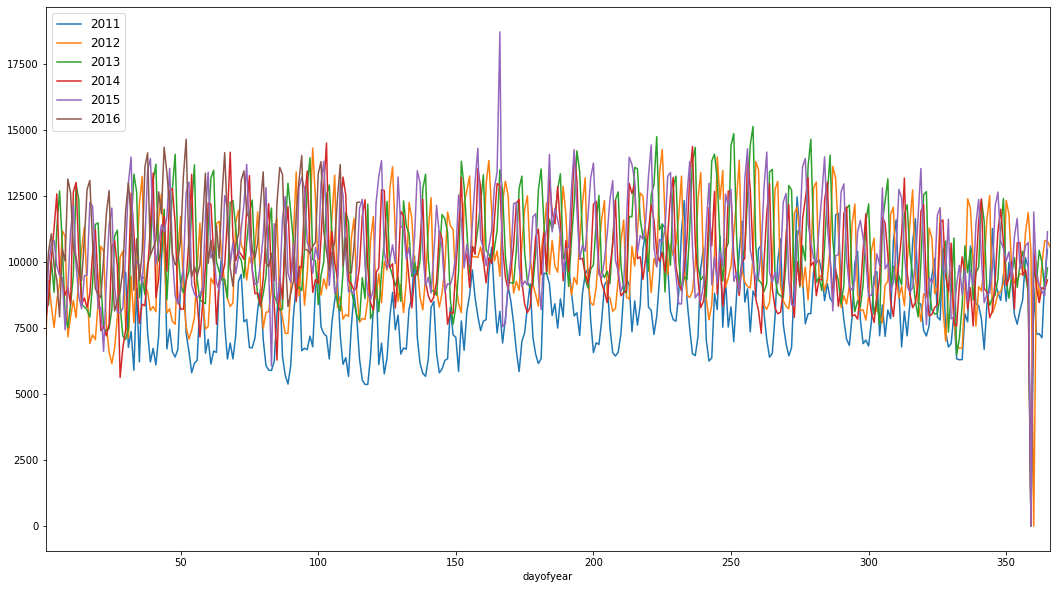

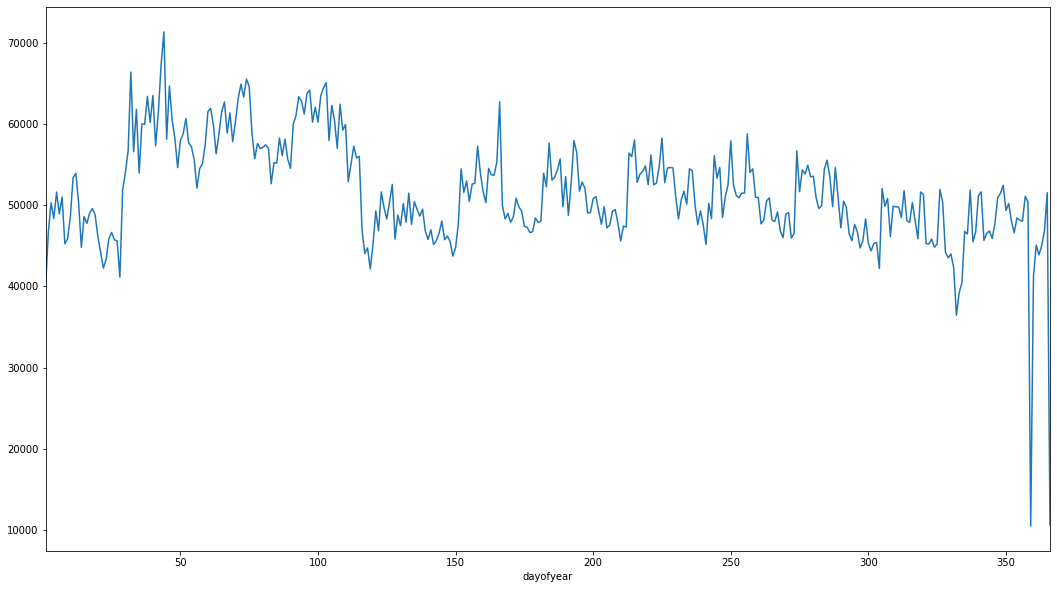

In [167]:
scatterbyday(texas)